In [1]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd

# Use the correct path from the sidebar
path = "/content/drive/MyDrive/Anomaly_Detection/train_test_network.csv"
df = pd.read_csv(path)

print(f"✅ Loaded: {df.shape}")
df.head()



✅ Loaded: (211043, 44)


,src_ip,src_port,dst_ip,dst_port,proto,service,duration,src_bytes,dst_bytes,conn_state,...,http_response_body_len,http_status_code,http_user_agent,http_orig_mime_types,http_resp_mime_types,weird_name,weird_addl,weird_notice,label,type
0,192.168.1.37,4444,192.168.1.193,49178,tcp,-,290.371539,101568,2592,OTH,...,0,0,-,-,-,-,-,-,1,backdoor
1,192.168.1.193,49180,192.168.1.37,8080,tcp,-,0.000102,0,0,REJ,...,0,0,-,-,-,-,-,-,1,backdoor
2,192.168.1.193,49180,192.168.1.37,8080,tcp,-,0.000148,0,0,REJ,...,0,0,-,-,-,-,-,-,1,backdoor
3,192.168.1.193,49180,192.168.1.37,8080,tcp,-,0.000113,0,0,REJ,...,0,0,-,-,-,-,-,-,1,backdoor
4,192.168.1.193,49180,192.168.1.37,8080,tcp,-,0.000130,0,0,REJ,...,0,0,-,-,-,-,-,-,1,backdoor


In [3]:
!pip install pandas scikit-learn river


In [4]:
# Shape of data
print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}")

# Check column names
print(df.columns.tolist())

# Check for nulls
print(df.isnull().sum())

# Check label values
if 'label' in df.columns:
    print("Labels:", df['label'].value_counts())
else:
    print("No 'label' column found – please share label column name.")


Rows: 211043, Columns: 44
['src_ip', 'src_port', 'dst_ip', 'dst_port', 'proto', 'service', 'duration', 'src_bytes', 'dst_bytes', 'conn_state', 'missed_bytes', 'src_pkts', 'src_ip_bytes', 'dst_pkts', 'dst_ip_bytes', 'dns_query', 'dns_qclass', 'dns_qtype', 'dns_rcode', 'dns_AA', 'dns_RD', 'dns_RA', 'dns_rejected', 'ssl_version', 'ssl_cipher', 'ssl_resumed', 'ssl_established', 'ssl_subject', 'ssl_issuer', 'http_trans_depth', 'http_method', 'http_uri', 'http_version', 'http_request_body_len', 'http_response_body_len', 'http_status_code', 'http_user_agent', 'http_orig_mime_types', 'http_resp_mime_types', 'weird_name', 'weird_addl', 'weird_notice', 'label', 'type']
src_ip                    0
src_port                  0
dst_ip                    0
dst_port                  0
proto                     0
service                   0
duration                  0
src_bytes                 0
dst_bytes                 0
conn_state                0
missed_bytes              0
src_pkts                

In [5]:
print(df.columns[-10:])  # Last 10 column names
df.iloc[0][-10:]         # Sample values from those columns


Index(['http_response_body_len', 'http_status_code', 'http_user_agent',
       'http_orig_mime_types', 'http_resp_mime_types', 'weird_name',
       'weird_addl', 'weird_notice', 'label', 'type'],
      dtype='object')


,0
http_response_body_len,0
http_status_code,0
http_user_agent,-
http_orig_mime_types,-
http_resp_mime_types,-
weird_name,-
weird_addl,-
weird_notice,-
label,1
type,backdoor


In [6]:
print("Binary Label Distribution:")
print(df['label'].value_counts())

print("\nAttack Type Distribution:")
print(df['type'].value_counts())


Binary Label Distribution:
label
1    161043
0     50000
Name: count, dtype: int64

Attack Type Distribution:
type
normal        50000
backdoor      20000
ddos          20000
dos           20000
injection     20000
password      20000
scanning      20000
ransomware    20000
xss           20000
mitm           1043
Name: count, dtype: int64


📝 Step 1: Drop Irrelevant Columns
Some columns like IP addresses, URIs, and weird_* fields are not helpful for ML models. These are identifiers or verbose metadata that may overfit the model or provide no generalization value. We drop them.

# Drop columns that are not useful for ML learning
# These include identifiers (IPs), URLs, and metadata fields

In [7]:
df = df.drop(columns=[
    'src_ip',         # IP address of the source
    'dst_ip',         # IP address of the destination
    'http_uri',       # Long URL string
    'http_user_agent',# Browser/user-agent strings
    'weird_name',     # Miscellaneous metadata
    'weird_addl',
    'weird_notice'
])

print("✅ Dropped irrelevant identifier/metadata columns.")

✅ Dropped irrelevant identifier/metadata columns.


# Show the datatype distribution: helps identify categorical vs numerical features

In [8]:
print("Data type breakdown:\n", df.dtypes.value_counts())

# For columns with type 'object', check how many unique categories each has
print("\nCategorical columns and their unique value counts:")
print(df.select_dtypes(include='object').nunique())

Data type breakdown:
 object     20
int64      16
float64     1
Name: count, dtype: int64

Categorical columns and their unique value counts:
proto                     3
service                   9
conn_state               13
dns_query               726
dns_AA                    3
dns_RD                    3
dns_RA                    3
dns_rejected              3
ssl_version               4
ssl_cipher                6
ssl_resumed               3
ssl_established           3
ssl_subject               6
ssl_issuer                5
http_trans_depth         11
http_method               4
http_version              2
http_orig_mime_types      3
http_resp_mime_types     10
type                     10
dtype: int64


In [9]:
from sklearn.preprocessing import LabelEncoder

# Loop through each object (categorical) column and apply label encoding
label_encoders = {}
for col in df.select_dtypes(include='object').columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le  # Store encoder for potential inverse transform later

print("✅ Encoded all categorical columns using LabelEncoder.")


✅ Encoded all categorical columns using LabelEncoder.


In [10]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

# Separate features (X) and labels (binary and multiclass)
X_raw = df.drop(columns=['label', 'type'])  # Features
y_binary = df['label']                      # Binary classification target
y_multiclass = df['type']                   # Multiclass attack type target

# Apply MinMax scaling
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_raw)

# Convert back to DataFrame for compatibility
X = pd.DataFrame(X_scaled, columns=X_raw.columns)

print("✅ All features scaled using MinMaxScaler (range 0–1).")


✅ All features scaled using MinMaxScaler (range 0–1).


# Binary Classification – Detect normal vs. anomalous traffic

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Split into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.2, random_state=42)

# Initialize the Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model on training data
model.fit(X_train, y_train)

# Predict on test set
y_pred = model.predict(X_test)

# Evaluate
print("✅ Binary Classification Results (Normal vs Anomaly):")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

✅ Binary Classification Results (Normal vs Anomaly):
Accuracy: 0.9990760264398588

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     10021
           1       1.00      1.00      1.00     32188

    accuracy                           1.00     42209
   macro avg       1.00      1.00      1.00     42209
weighted avg       1.00      1.00      1.00     42209


Confusion Matrix:
 [[ 9992    29]
 [   10 32178]]


#Step 6: Train a Multiclass Classification Model

### 🎯 Multiclass Classification — Detect Specific Attack Types

In this step, we use the `type` column from the TON_IoT dataset to classify each network traffic record into its specific attack category (e.g., DoS, XSS, ransomware, etc.). We use a Random Forest model with 80-20 train-test split.

The classification report shows very high precision and recall for most classes. The accuracy reaches **~98.9%**, and even minority classes like `MITM` are handled well. This demonstrates the model's capability to detect and distinguish between a variety of cyber-attacks in IoT networks.


In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Split for multiclass target
X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(
    X, y_multiclass, test_size=0.2, random_state=42
)

# New model for multiclass
clf_multi = RandomForestClassifier(n_estimators=100, random_state=42)
clf_multi.fit(X_train_multi, y_train_multi)

# Predictions
y_pred_multi = clf_multi.predict(X_test_multi)

# Evaluation
print("🧠 Multiclass Classification Results (Attack Type):")
print("Accuracy:", accuracy_score(y_test_multi, y_pred_multi))
print("\nClassification Report:\n", classification_report(y_test_multi, y_pred_multi))
print("\nConfusion Matrix:\n", confusion_matrix(y_test_multi, y_pred_multi))

🧠 Multiclass Classification Results (Attack Type):
Accuracy: 0.9894335331327442

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3919
           1       0.99      0.98      0.98      4065
           2       0.99      0.98      0.99      3934
           3       0.97      0.97      0.97      3978
           4       0.71      0.85      0.78       213
           5       1.00      1.00      1.00     10021
           6       0.99      0.99      0.99      3968
           7       1.00      1.00      1.00      4047
           8       0.99      0.99      0.99      4015
           9       0.98      0.98      0.98      4049

    accuracy                           0.99     42209
   macro avg       0.96      0.97      0.97     42209
weighted avg       0.99      0.99      0.99     42209


Confusion Matrix:
 [[3917    0    0    2    0    0    0    0    0    0]
 [   0 3986    1   36    0    3    2    0    0   37]
 [   0    

###  Feature Importance Visualization — Random Forest

To better understand how the model makes its predictions, we visualize the top features contributing to attack type classification. This helps in interpreting the model and identifying the most influential factors for detecting anomalies in IoT network traffic.


/tmp/ipython-input-13-1525715403.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feat_df, x='Importance', y='Feature', palette='viridis')
/tmp/ipython-input-13-1525715403.py:19: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


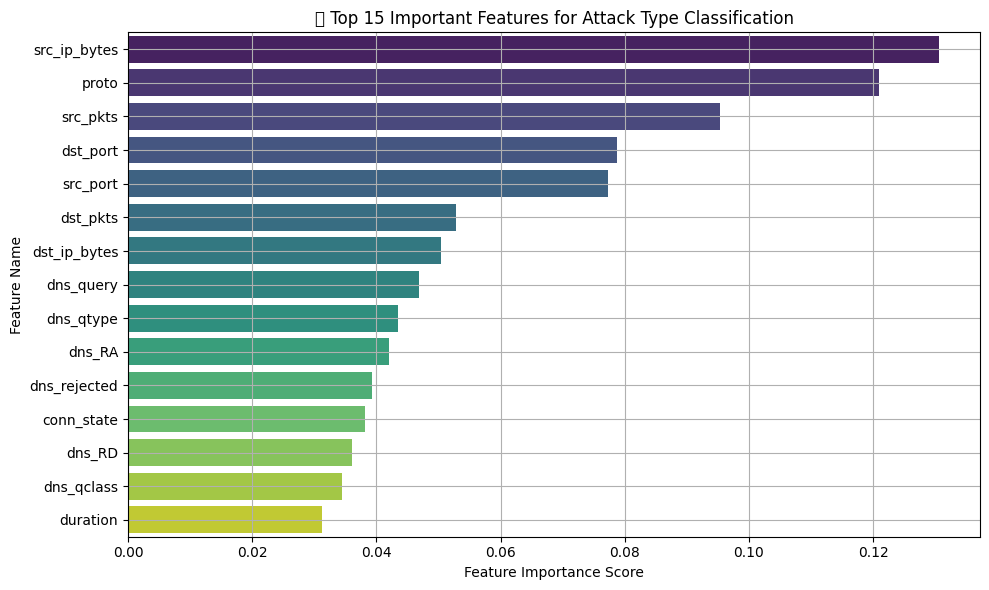

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Get feature importances from trained Random Forest model
importances = model.feature_importances_
feature_names = X.columns

# Create a DataFrame for easy plotting
feat_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_df = feat_df.sort_values(by='Importance', ascending=False).head(15)  # Top 15 features

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(data=feat_df, x='Importance', y='Feature', palette='viridis')
plt.title("🔍 Top 15 Important Features for Attack Type Classification")
plt.xlabel("Feature Importance Score")
plt.ylabel("Feature Name")
plt.tight_layout()
plt.grid(True)
plt.show()


In [14]:
# Display dataset shape (rows, columns)
print(f"📐 Shape of the dataset: {df.shape}")

# View column names
print("\n🧾 Column Names:\n", df.columns.tolist())

# Display data types and non-null counts
print("\n📊 Dataset Info:")
df.info()

# Display summary statistics for numerical columns
print("\n📈 Summary Statistics:")
df.describe()

# Count missing values
print("\n❗ Missing Values:")
print(df.isnull().sum())


📐 Shape of the dataset: (211043, 37)

🧾 Column Names:
 ['src_port', 'dst_port', 'proto', 'service', 'duration', 'src_bytes', 'dst_bytes', 'conn_state', 'missed_bytes', 'src_pkts', 'src_ip_bytes', 'dst_pkts', 'dst_ip_bytes', 'dns_query', 'dns_qclass', 'dns_qtype', 'dns_rcode', 'dns_AA', 'dns_RD', 'dns_RA', 'dns_rejected', 'ssl_version', 'ssl_cipher', 'ssl_resumed', 'ssl_established', 'ssl_subject', 'ssl_issuer', 'http_trans_depth', 'http_method', 'http_version', 'http_request_body_len', 'http_response_body_len', 'http_status_code', 'http_orig_mime_types', 'http_resp_mime_types', 'label', 'type']

📊 Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211043 entries, 0 to 211042
Data columns (total 37 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   src_port                211043 non-null  int64  
 1   dst_port                211043 non-null  int64  
 2   proto                   211043 non-null  int64  


Find and remove any duplicate rows if needed.

In [15]:
# Count duplicate rows
duplicate_count = df.duplicated().sum()
print(f"\n🧹 Duplicate rows: {duplicate_count}")

# Remove duplicates if necessary
df = df.drop_duplicates()



🧹 Duplicate rows: 27461


clean the dataset by dropping the duplicates and resetting the index:

In [16]:
# Drop duplicate rows
df = df.drop_duplicates()

# Reset index after dropping duplicates
df.reset_index(drop=True, inplace=True)

# Confirm new shape
print(f"✅ Dataset shape after removing duplicates: {df.shape}")


✅ Dataset shape after removing duplicates: (183582, 37)


In [17]:
# Display number of unique values in each column
print("\n🔢 Unique Values per Column:")
print(df.nunique())



🔢 Unique Values per Column:
src_port                  26628
dst_port                   2039
proto                         3
service                       9
duration                  68570
src_bytes                  2199
dst_bytes                  2338
conn_state                   13
missed_bytes                694
src_pkts                    274
src_ip_bytes               3648
dst_pkts                    203
dst_ip_bytes               3304
dns_query                   726
dns_qclass                    3
dns_qtype                    12
dns_rcode                     4
dns_AA                        3
dns_RD                        3
dns_RA                        3
dns_rejected                  3
ssl_version                   4
ssl_cipher                    6
ssl_resumed                   3
ssl_established               3
ssl_subject                   6
ssl_issuer                    5
http_trans_depth             11
http_method                   4
http_version                  2
http_reques

Check for Constant or Single-Value Columns

In [18]:
# Find columns with only 1 unique value
single_value_cols = [col for col in df.columns if df[col].nunique() == 1]
print("\n⚠️ Columns with only one unique value:", single_value_cols)



⚠️ Columns with only one unique value: []


#Visualizing Feature Distributions

### 📊 Feature Distribution Plots

Let’s visualize the distribution of a few key numerical features to spot skewness, outliers, or interesting patterns.


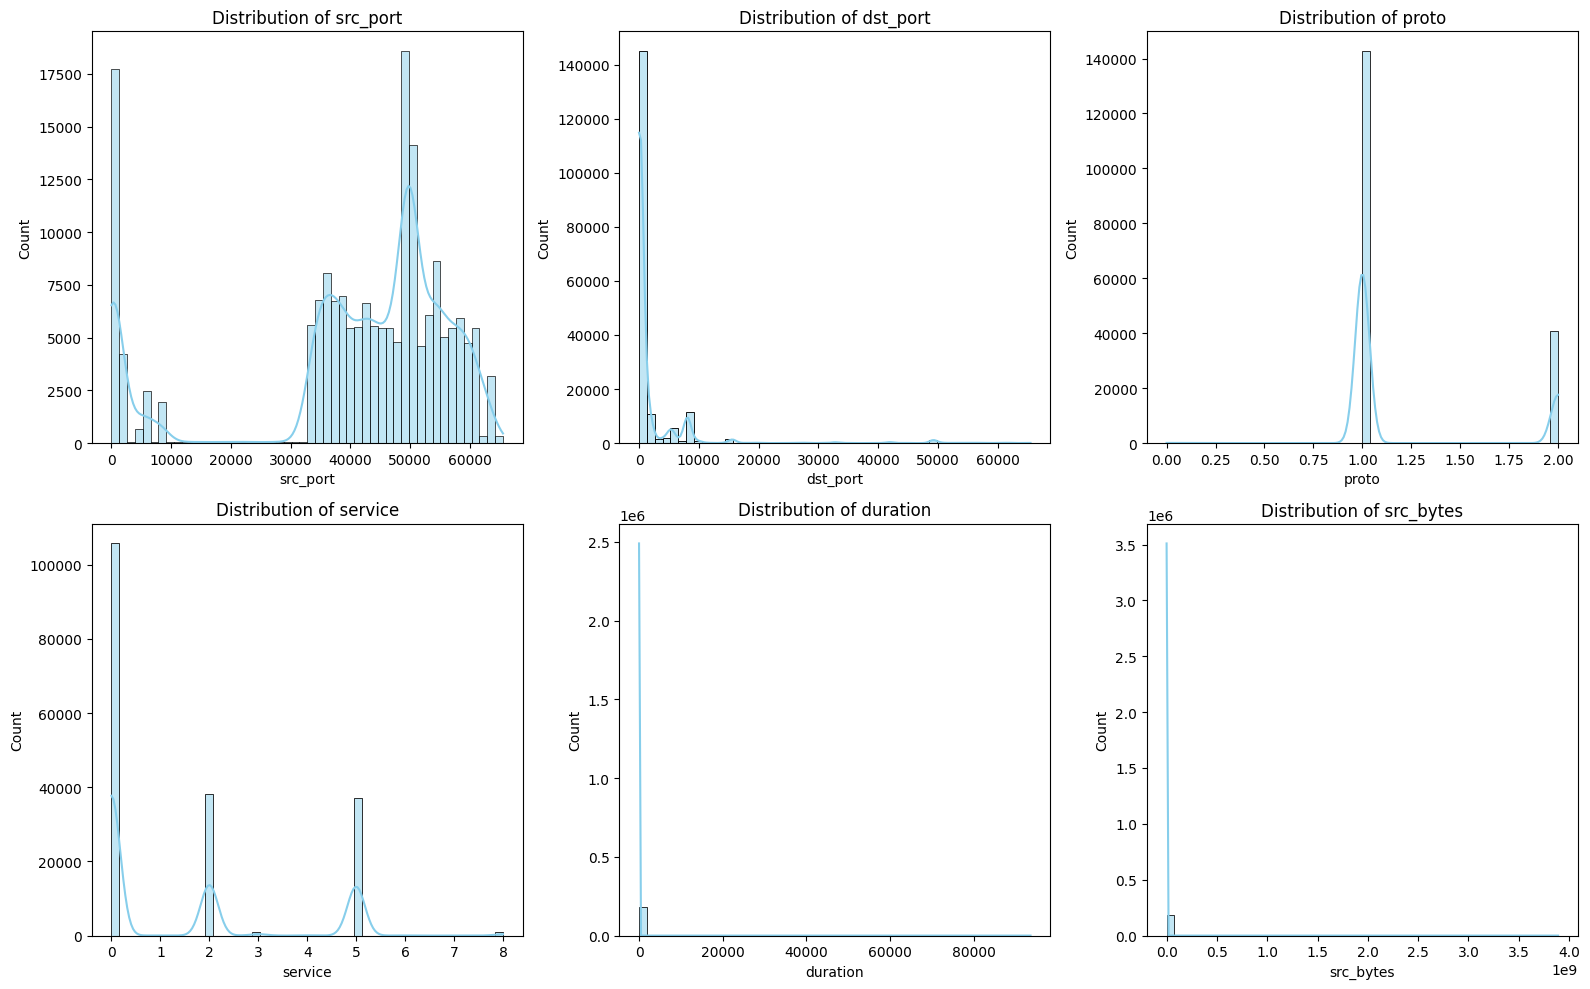

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Pick top 6 numeric columns
numeric_cols = df.select_dtypes(include='number').columns[:6]

# Plot distributions
plt.figure(figsize=(16, 10))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(2, 3, i)
    sns.histplot(df[col], bins=50, kde=True, color='skyblue')
    plt.title(f'Distribution of {col}')
    plt.tight_layout()
plt.show()


### 🔗 Correlation Heatmap

We now visualize the correlation between all numerical features to detect multicollinearity.


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128279 (\N{LINK SYMBOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


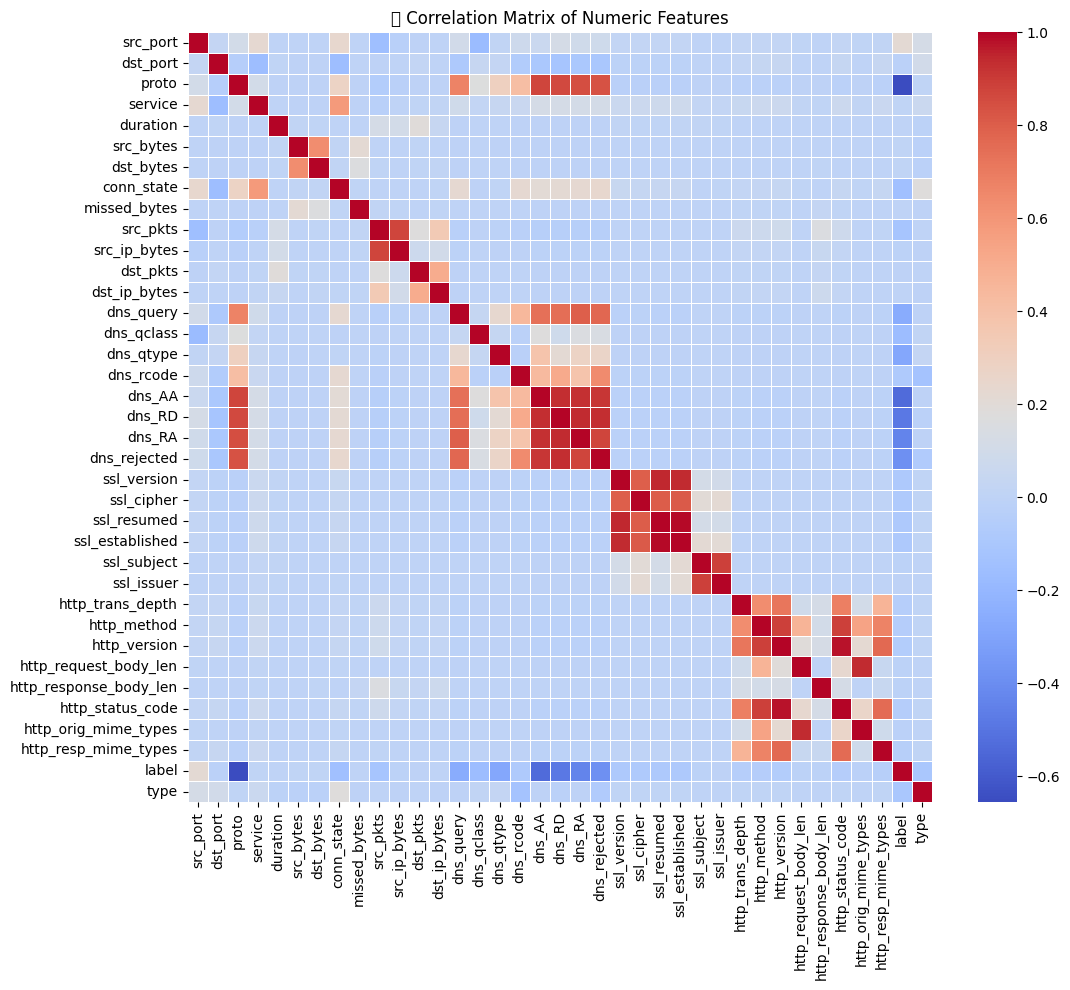

In [20]:
# Compute correlation
corr_matrix = df.corr(numeric_only=True)

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('🔗 Correlation Matrix of Numeric Features')
plt.show()


#Outlier Detection using Box Plots

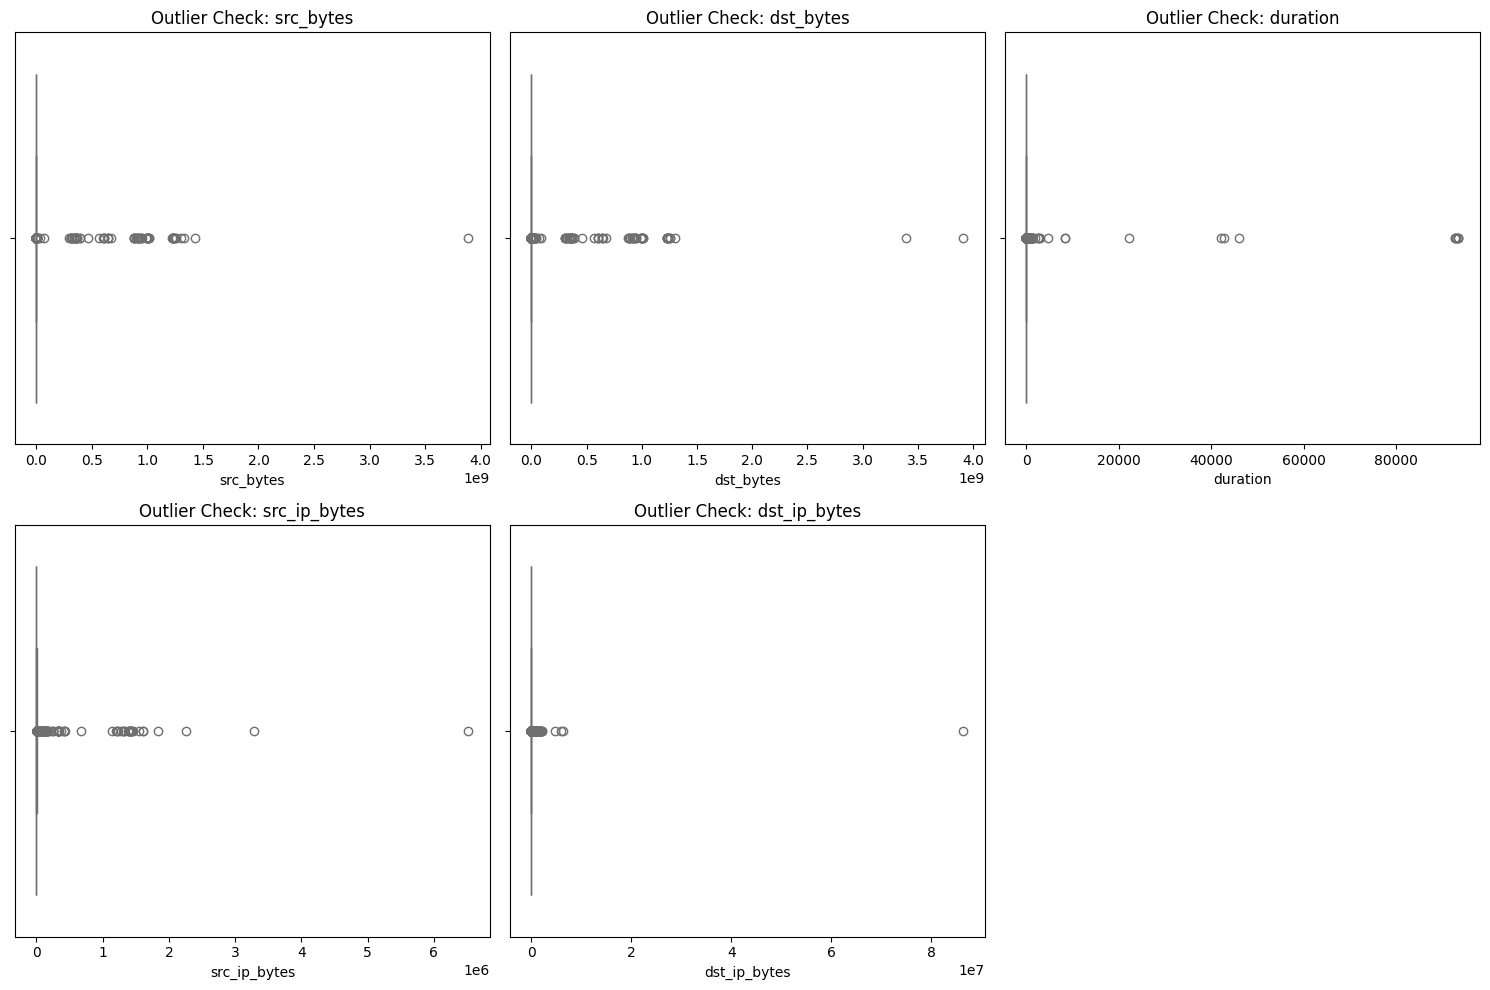

In [21]:
# 📦 Box plots for identifying outliers in selected numerical features
import matplotlib.pyplot as plt
import seaborn as sns

# List of features that showed extreme skew in earlier plots
outlier_cols = ['src_bytes', 'dst_bytes', 'duration', 'src_ip_bytes', 'dst_ip_bytes']

plt.figure(figsize=(15, 10))
for i, col in enumerate(outlier_cols, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x=df[col], color='skyblue')
    plt.title(f'Outlier Check: {col}')
plt.tight_layout()
plt.show()


#Check for Class Imbalance in type and label

/tmp/ipython-input-22-97913188.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=df, palette='coolwarm')
/tmp/ipython-input-22-97913188.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='type', data=df, order=df['type'].value_counts().index, palette='viridis')


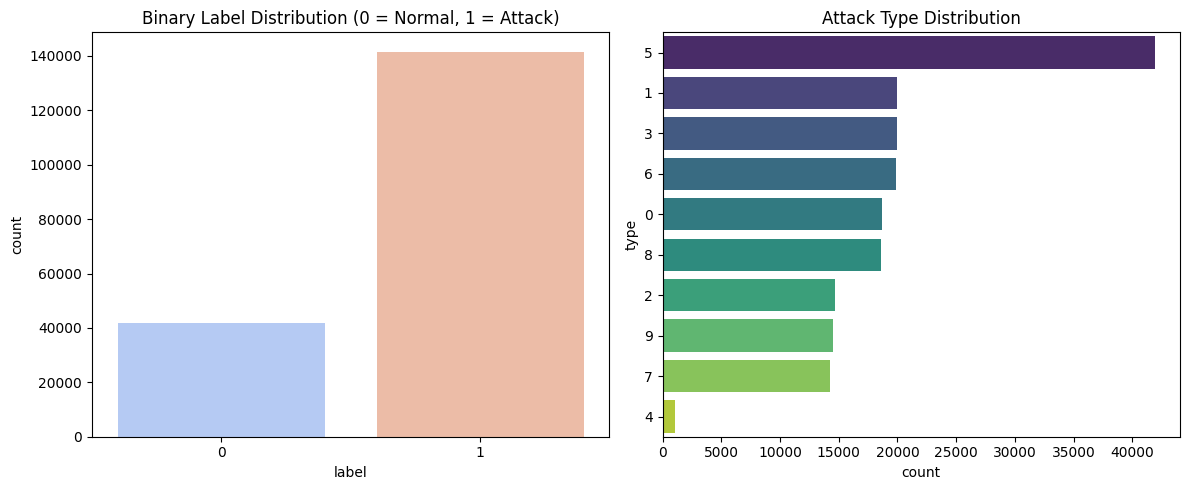

In [22]:
# 📊 Check class balance for binary and multiclass targets
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.countplot(x='label', data=df, palette='coolwarm')
plt.title("Binary Label Distribution (0 = Normal, 1 = Attack)")

plt.subplot(1, 2, 2)
sns.countplot(y='type', data=df, order=df['type'].value_counts().index, palette='viridis')
plt.title("Attack Type Distribution")

plt.tight_layout()
plt.show()


In [23]:
# 📌 Distribution of protocol and service types
categorical_cols = ['proto', 'service', 'conn_state']

for col in categorical_cols:
    print(f"🔎 Unique values in {col}:")
    print(df[col].value_counts(), "\n")


🔎 Unique values in proto:
proto
1    142772
2     40663
0       147
Name: count, dtype: int64 

🔎 Unique values in service:
service
0    105768
2     38249
5     37029
3      1065
8      1025
4       184
1       136
6       108
7        18
Name: count, dtype: int64 

🔎 Unique values in conn_state:
conn_state
10    50210
6     48513
1     38348
0     11244
7     10764
11     6832
9      6557
12     5627
4      1989
5      1577
2      1178
8       627
3       116
Name: count, dtype: int64 



#Data Preprocessing

Step 1: Remove Duplicates

In [24]:
# Remove duplicates (if not done earlier)
df = df.drop_duplicates()
print(f"✅ Data after removing duplicates: {df.shape}")


✅ Data after removing duplicates: (183582, 37)


# Step 2: Drop Useless or Highly Correlated Features

In [25]:
# Drop features with low variance or high correlation (optional step after EDA)
cols_to_drop = ['http_version', 'http_resp_mime_types', 'http_orig_mime_types']  # example
df = df.drop(columns=cols_to_drop, errors='ignore')


#Step 3: Encode Categorical Features

In [26]:
from sklearn.preprocessing import LabelEncoder

# Identify object (non-numeric) columns
cat_cols = df.select_dtypes(include='object').columns.tolist()
print(f"Categorical Columns: {cat_cols}")

# Apply label encoding to each
le = LabelEncoder()
for col in cat_cols:
    df[col] = le.fit_transform(df[col])


Categorical Columns: []


In [27]:
from sklearn.preprocessing import LabelEncoder

# List of categorical columns to encode
categorical_cols = ['proto', 'service', 'conn_state']

# Encode each categorical column
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le  # Save encoder for possible inverse_transform later

print("✅ Categorical features label-encoded.")


✅ Categorical features label-encoded.


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


✅ Model Comparison Completed


,Model,Accuracy,Precision,Recall,F1 Score
4,Random Forest,0.999891,0.999891,0.999891,0.999891
1,Decision Tree,0.999782,0.999782,0.999782,0.999782
2,K-Nearest Neighbors,0.985238,0.985194,0.985238,0.985175
0,Logistic Regression,0.797587,0.796039,0.797587,0.796791
3,Naive Bayes,0.227497,0.734847,0.227497,0.085818


/tmp/ipython-input-28-3898444337.py:55: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


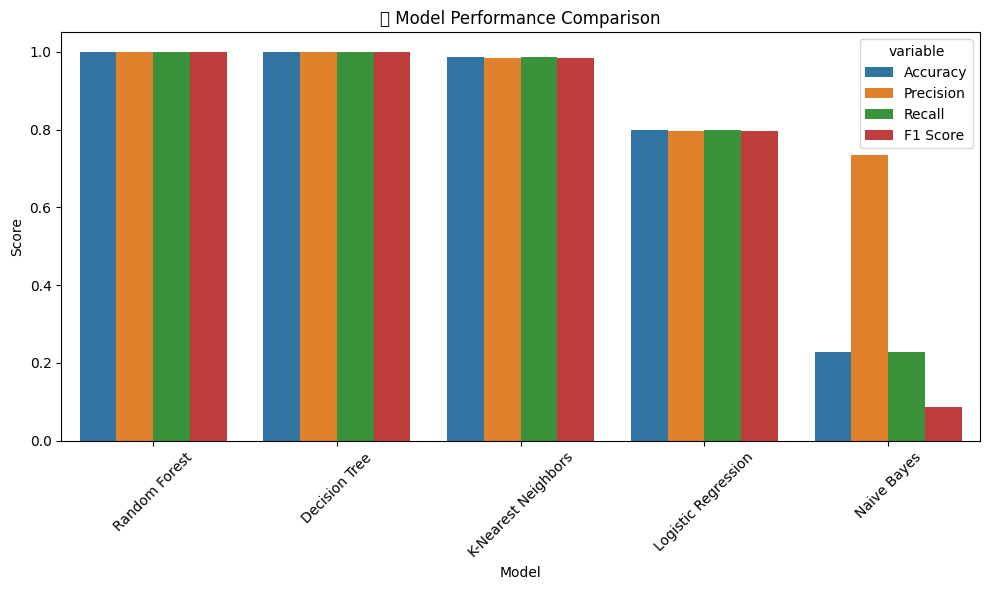

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# Split features and labels
X = df.drop("label", axis=1)
y = df["label"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB(),
    "Random Forest": RandomForestClassifier()
}

# Store results
results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, average='weighted'),
        "Recall": recall_score(y_test, y_pred, average='weighted'),
        "F1 Score": f1_score(y_test, y_pred, average='weighted')
    })

# Convert to DataFrame
results_df = pd.DataFrame(results).sort_values(by="F1 Score", ascending=False)

# Display table
print("✅ Model Comparison Completed")
display(results_df)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=results_df.melt(id_vars="Model"), x="Model", y="value", hue="variable")
plt.title("🔍 Model Performance Comparison")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


###  Real-Time Anomaly Detection Simulation

To emulate a real-world streaming scenario, we simulate real-time detection by processing network traffic one row at a time. The model predicts whether each record is normal or anomalous. This setup can later be extended to real-time data using MQTT, Kafka, or direct sensor input.


In [29]:
import time
from IPython.display import clear_output

# Use best model (Random Forest) for real-time simulation
stream_model = RandomForestClassifier()
stream_model.fit(X_train, y_train)

# Simulate 10 records from test set as if streaming one by one
print("📡 Simulating real-time anomaly detection...\n")
for i in range(10):
    record = X_test.iloc[i].values.reshape(1, -1)
    prediction = stream_model.predict(record)[0]
    label = "🔴 Anomaly" if prediction == 1 else "🟢 Normal"

    clear_output(wait=True)
    print(f"📶 Record #{i+1}")
    print("Prediction:", label)
    time.sleep(1)  # Simulate delay like streaming


📶 Record #10
Prediction: 🔴 Anomaly


In [30]:
import joblib

joblib.dump(model, 'rf_model.pkl')
joblib.dump(label_encoders, 'label_encoders.pkl')


['label_encoders.pkl']

In [31]:
from google.colab import files

files.download('rf_model.pkl')
files.download('label_encoders.pkl')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>